# Optimization problem
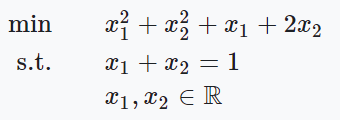

Definition of problem

In [ ]:
def f_constrained(x):
    return x[0]**2 + x[1]**2 + x[0] + 2 * x[1], [], [x[0] + x[1] - 1]

# Task 1

Solve the problem using the penalty function method. Note that it is not sufficient to use a fixed value for r.

Definitions of how is function penalizate and definition of penalized function itself

In [ ]:
def alpha(x, f):
    (_, ieq, eq) = f(x)
    return sum([min([0, ieq_j])**2 for ieq_j in ieq]) + sum([eq_k**2 for eq_k in eq])

def penalized_function(x, f, r):
    return f(x)[0] + r * alpha(x, f)

Definition of function where is solved problem using penalty function and penalty r is iterativly updated.

In [ ]:
from scipy.optimize import minimize

def iteratively_penalty_optimization(x0, f_constrained, r_initial, epsilon):
    x = x0
    r = r_initial
    iterations = 0

    # solution ends when conditions will be fullifill with some threshld
    feasible = False
    while not feasible:
        # optimization with the current value of r and  updated starting point x
        res = minimize(lambda x: penalized_function(x, f_constrained, r), x, method='Nelder-Mead', options={'disp': True})

        # update the penalty parameter r, i tried different approches, which i will compare in third task
        r *= 2
        # update staring point
        x = res.x

        # check if conditions are satisifed. In order this example has only equality condition(s) i chcek only that.
        # i set some "threshold" values epsilon for feasible solution.
        (f_val,ieq,eq) = f_constrained(res.x)
        if all(eq_k >= -epsilon and eq_k <= epsilon for eq_k in eq):
            feasible = True

        iterations += 1

    return res, f_val, iterations

Results:

In [ ]:
# initial values
x_initial = [0, 0]
r_initial = 1
epsilon = 0.0001  # threshold
result, function_value, iterations = iteratively_penalty_optimization(x_initial, f_constrained, r_initial, epsilon)

print("------------------RESULT------------------")
print("Optimal solution:", result.x)
print("Function value in optimal solution:", function_value)
print("Iterations:", iterations)

# Task 2

Solve the problem (i.e., approximate the optimal solution) using the barrier function method. Note that you need to do something a bit clever.

While barrier function can have only ineqality condition, i changed definition of optimization problem for inequality.

In [ ]:
def f_constrained(x):
    return x[0]**2 + x[1]**2 + x[0] + 2 * x[1], [x[0] + x[1] - 1,- x[0] - x[1] + 1], []

Definition of berrier function ane parameters

In [ ]:
def beta(x,f):
    _,ieq,_ = f(x)
    try:
        value=sum([1/max([0,ieq_j]) for ieq_j in ieq])
    except ZeroDivisionError:
        value = float("inf")
    return value

In [ ]:
def function_with_barrier(x,f,r):
    return f(x)[0]+r*beta(x,f)

Definition of barrier optimization

In [ ]:
def barrier_optimization(x0, f_constrained, r_initial, step):
    x = x0
    r = r_initial
    feasible = False
    iterations = 0
    # in barrier optimization, r converge to zero from right - positive numbers , so i set stopping criteria while r > 0
    # so it's kind of maximum number of iterations
    while r > 0:
            # Perform the optimization with the current value of r and starting point x
        res = minimize(lambda x: function_with_barrier(x, f_constrained, r), x, method='Nelder-Mead', options={'disp': True})
        #res = minimize(lambda x: function_with_barrier(x, f_constrained, r), x, method='CG', options={'disp': True})
        #res = minimize(lambda x: function_with_barrier(x, f_constrained, r), x, method='CG', jac=grad(f_constrained), options={'disp': True})
        # in barrier optimization, r converge to zero from right - positive numbers
        r -= step
        x = res.x
        iterations += 1

    return res, iterations

Results:

In [ ]:
def f_constrained(x):
    return x[0]**2 + x[1]**2 + x[0] + 2 * x[1], [x[0] + x[1] - 1], [] #, -(x[0] + x[1] - 1) #[x[0] + x[1] - 1

In [ ]:
# initial values
x_initial = [-2, 3]
r_initial = 1
step = 0.001  # step

result, iterations = barrier_optimization(x_initial, f_constrained, r_initial, step)
function_value,_,_ = f_constrained(result.x)

print("------------------RESULT------------------")
print("Optimal solution:", result.x)
print("Function value in optimal solution:", function_value)
print("Iterations:", iterations)

# NOT WORKING AT ALL, I GIVE SOME MORE INFORMATION ABOUT IT IN THIRD TASK

<ipython-input-80-bf8e312e81e7>:10: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(lambda x: function_with_barrier(x, f_constrained, r), x, method='Nelder-Mead', options={'disp': True})


------------------RESULT------------------
Optimal solution: [-2.  3.]
Function value in optimal solution: 17.0
Iterations: 1000


# Task 3

Solve the problem using the projected gradient method. Compare the performance to the penalty function and barrier function methods.

Definitions of functions

In [ ]:
import autograd.numpy as anp
import numpy as np
from autograd import grad

def project_vector(A, vector):
    # Convert A into a matrix
    A_matrix = anp.matrix(A)
    # Construct the "first row" of the matrix [[I,A^T],[A,0]]
    left_matrix_first_row = anp.concatenate((anp.identity(len(vector)), A_matrix.transpose()), axis=1)
    # Construct the "second row" of the matrix
    left_matrix_second_row = anp.concatenate((A_matrix, anp.matrix(anp.zeros([len(A), len(A)]))), axis=1)
    # Combine the whole matrix by combining the rows
    left_matrix = anp.concatenate((left_matrix_first_row, left_matrix_second_row), axis=0)
    # Solve the system of linear equalities from the previous page
    return anp.linalg.solve(left_matrix, \
                            anp.concatenate((anp.matrix(vector).transpose(), \
                                             anp.zeros([len(A), 1])), axis=0))[:len(vector)]

def projected_gradient_method(f, A, start, step, precision):
    f_old = float('Inf')
    x = anp.array(start, dtype=float)
    steps = []
    grad_f = grad(f)
    iters = 0
    while anp.abs(f_old - f(x)) > precision:
        # store the current function value
        f_old = f(x)
        # compute gradient
        gradient = grad_f(x)
        # project negative gradient
        d = project_vector(A, [-i for i in gradient])
        # take transpose
        d = d.reshape(1, -1)
        # take step
        x = anp.array(x + step * d)[0]
        # compute f in new point+
        f_new = f(x)
        # record new step
        steps.append(x)
        # update iterations counter
        iters += 1
    return x, steps, iters

Results:

In [ ]:
f = lambda x: x[0]**2 + x[1]**2 + x[0] + 2 * x[1]
A = [[1, 1]] # matrix of coefficinets of contraints
start = [-2.0, 3.0]
(x, steps, iters) = projected_gradient_method(f, A, start, 0.6, 0.000001)
print("Optimal solution:", x)
print("Function value in optimal solution:", f(x))
#print("Steps taken:", steps)
print("Condition equality:", np.matrix(A)*np.matrix(x).transpose())
print("Iterations:", iters)

Optimal solution: [0.7500352 0.2499648]
Function value in optimal solution: 1.8750000024780802
Condition equality: [[1.]]
Iterations: 7


# Comparison of solutions performance

**Penalty function results:**

*For epsilon = 0.0001*
- for initial penalty r = 1, and in each iteration increase * 2

  ```
  Optimal solution: [0.74992197 0.25000099]
  Function value in optimal solution: 1.8748074167404702
  Iterations: 15
  ```
- for initial penalty r = 1, and in each iteration increase + 1

  ```
  Optimal solution: [0.75000229 0.24989809]
  Function value in optimal solution: 1.874750955435673
  Iterations: 12523
  ```
- for initial penalty r = 1, and in each iteration increase * 10

  ```
  Optimal solution: [0.74998148 0.25000583]
  Function value in optimal solution: 1.8749682907858365
  Iterations: 6
  ```

*When i then tried to change epsilon = 0.1 it of course gives fewer iterations but also really worst results.*

*Last thing i tried to set epsilon = 0.000001 ane here are results:*



- for initial penalty r = 1, and in each iteration increase * 2
```
Optimal solution: [0.75000563 0.24999431]
Function value in optimal solution: 1.874999859237442
Iterations: 25
```

- for penalty increase by 1 it make not sense at all... ( to many iterations)

- for initial penalty r = 1, and in each iteration increase * 10
```
Optimal solution: [0.75003479 0.2499652 ]
Function value in optimal solution: 1.8749999670609903
Iterations: 9
```

So, overall, penalty function with iteration with just adding 1 isnt very good in this problem. The best solution looks multiply r * 10. Also when we set epsilon to smaller number, it tooks only a few more iteration, but also results are more precise.
In comparision with projected gradinet function, it is not that bad when we set the right parameters, but still it took much more operations, while i try to solve optimization problem everytime with new r.



**Barrier function results:**

I had an issue with this task, and it doesn't work at all. When i tried to do this takst with two inequality contrains:


```
def f_constrained(x):
    return x[0]**2 + x[1]**2 + x[0] + 2 * x[1], [x[0] + x[1] - 1,- x[0] - x[1] + 1], []
```
it works very bad, how you can also see on results above in task 2. I also tried to change opitimizar, CG works little bit better, but still not any reasonable results. Then i try to remove one conidiion, the negative one and try to define function only like this:
```
def f_constrained(x):
    return x[0]**2 + x[1]**2 + x[0] + 2 * x[1], [x[0] + x[1] - 1], []
```
and i get this results:

```
# step = 0.0001
Optimal solution: [0.75002035 0.24997986]
Function value in optimal solution: 1.8750005080953414
Iterations: 10001

# step = 0.001
Optimal solution: [0.7599449 0.2599734]
Function value in optimal solution: 1.9249941144753207
Iterations: 1000
```
But i know, that is not corret, even it gives corrent results.


**Projected gradient results:**


```
Optimal solution: [0.7500352 0.2499648]
Function value in optimal solution: 1.8750000024780802
Condition equality: [[1.]]
Iterations: 7
```
I can say, this method was the best one, it took the smallest number of operations and also results are enough presice.





# Task 4

 Check the 'necessary first-order KKT conditions for the solution that you found.

I assume that i can say i found a little rounded solution x* = (0.75, 0.25) and when i check KKT conditions, i found that this solution x* is local minimum.

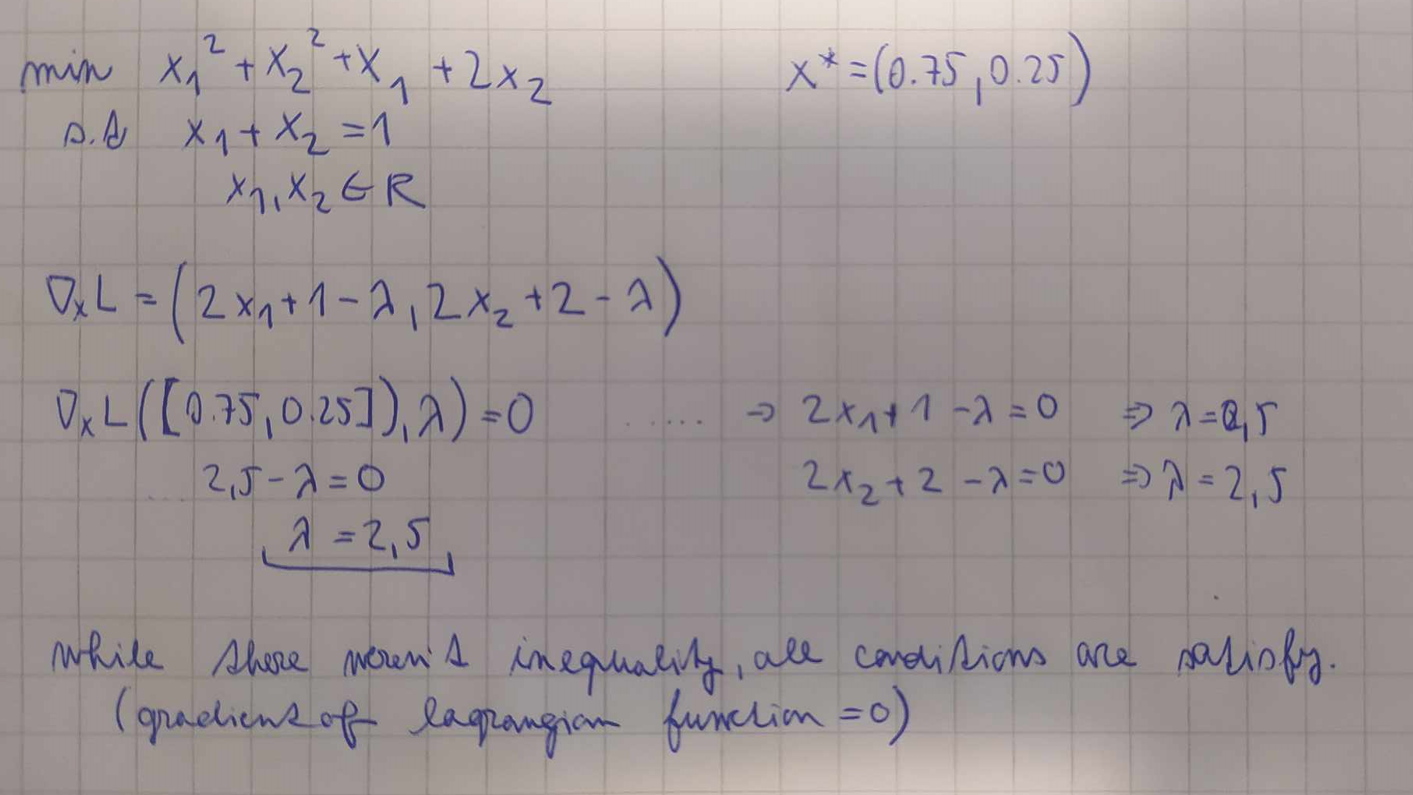